# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb

In [2]:
torch.__version__

'2.2.2'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed, get_activation
from base.model.decoder import Decoder
from base.data.combined import GeneExpressionDatasetCombined
from base.engine.train import train_midgd

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 14

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cuda


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_transposed.tsv", sep='\t', index_col=[0])
# tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_transposed.tsv", sep='\t', index_col=[0])
tcga_mrna = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

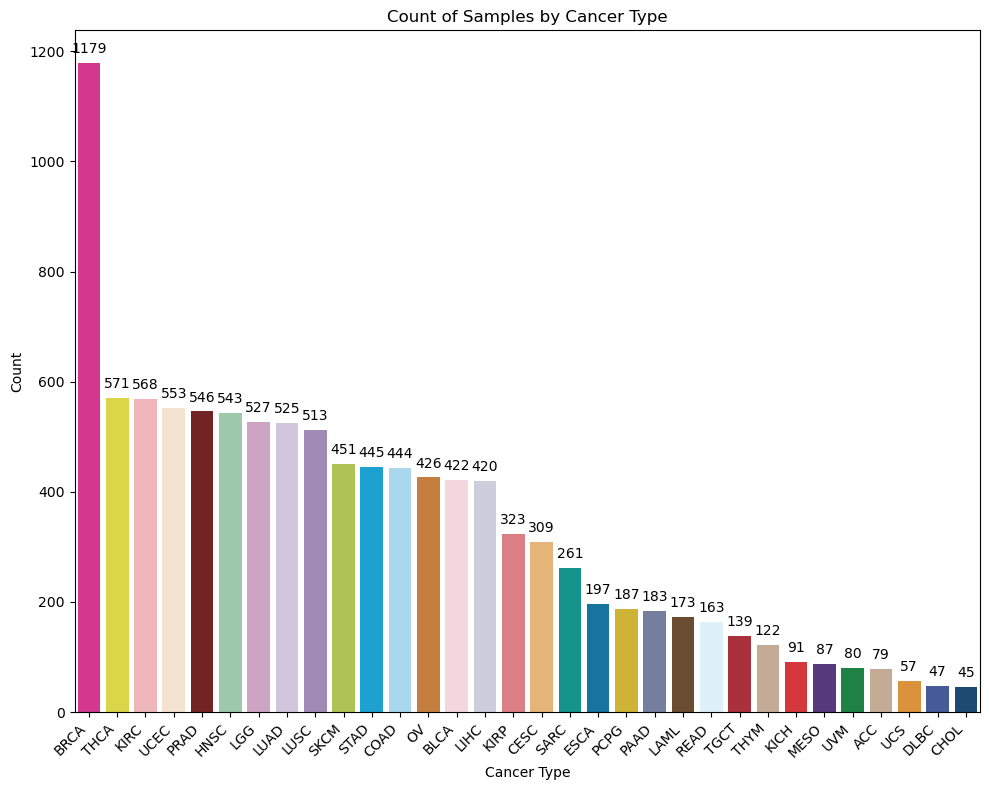

In [6]:
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

primary_site_counts = tcga_mrna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(10, 8))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

In [7]:
# make data split for train and validation sets
mrna_out_dim = tcga_mrna.shape[1]-4
mirna_out_dim = tcga_mirna.shape[1]-4

# shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

In [8]:
# make data split for train, validation, and test sets
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

# Calculate split indices
total_samples = len(tcga_mrna)
train_end = int(train_ratio * total_samples)
val_end = train_end + int(val_ratio * total_samples)

# Split the data
train_mrna = tcga_mrna.iloc[:train_end]
val_mrna = tcga_mrna.iloc[train_end:val_end]
test_mrna = tcga_mrna.iloc[val_end:]

train_mirna = tcga_mirna.iloc[:train_end]
val_mirna = tcga_mirna.iloc[train_end:val_end]
test_mirna = tcga_mirna.iloc[val_end:]

# Train, val, and test data loaders
# Default scaling_type = "mean"
train_dataset = GeneExpressionDatasetCombined(train_mrna, train_mirna)
validation_dataset = GeneExpressionDatasetCombined(val_mrna, val_mirna)
test_dataset = GeneExpressionDatasetCombined(test_mrna, test_mirna)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=256, 
                                           shuffle=True,
                                           num_workers=num_workers,
                                           pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=256, 
                                                shuffle=True,
                                                num_workers=num_workers,
                                                pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True,
                                          num_workers=num_workers,
                                          pin_memory=True)

In [9]:
print(train_dataset.mrna_data.shape)
print(validation_dataset.mrna_data.shape)
print(test_dataset.mrna_data.shape)

print(train_dataset.mirna_data.shape)
print(validation_dataset.mirna_data.shape)
print(test_dataset.mirna_data.shape)

print(mrna_out_dim)
print(mirna_out_dim)

torch.Size([7473, 19784])
torch.Size([1601, 19784])
torch.Size([1602, 19784])
torch.Size([7473, 2450])
torch.Size([1601, 2450])
torch.Size([1602, 2450])
19784
2450


In [10]:
n_tissues = len(np.unique(train_dataset.label))
n_tissues

32

# Model Setup

In [11]:
# hyperparameters
latent_dim = 20
hidden_dims = [128, 256, 256]
reduction_type = "sum" # output loss reduction

In [12]:
# decoder setup

# set up an output module for the mRNA expression data
mrna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], mrna_out_dim)
    )
output_mrna_layer = NB_Module(mrna_out_fc, mrna_out_dim, scaling_type="mean")
output_mrna_layer.n_features = mrna_out_dim

# set up an output module for the miRNA expression data
mirna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], mirna_out_dim)
    )
output_mirna_layer = NB_Module(mirna_out_fc, mirna_out_dim, scaling_type="mean")
output_mirna_layer.n_features = mirna_out_dim

# set up the decoder
decoder = Decoder(latent_dim, hidden_dims, [output_mrna_layer, output_mirna_layer]).to(device)

# setup gmm init
gmm_mean_scale = 10.0 # usually between 2 and 10
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

In [13]:
# init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

# Training

In [14]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'main_tcga_mirna_midgd'

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="miDGD",
    
    # track hyperparameters and run metadata
    config={
        "learning_rate": {'dec':0.002,'rep':0.01,'gmm':0.01},
        "architecture": "DGD",
        "dataset": "miRNA",
        "epochs": 401,
        "hidden_dim": [128, 256, 512]
    }
)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find main_tcga_mirna_midgd.
wandb: Currently logged in as: farzamani (midgd). Use `wandb login --relogin` to force relogin


  0%|                                                                                                                                                                                                                                                         | 0/401 [00:00<?, ?it/s]

0 test_recon: 7.112305365726433 test_gmm: 10.071149440291224 test_rmse: 0.23820228028639936 test_mse: 17.909338889756402 test_mae: 0.013140894337641604 test_r2: 0.0003592839917117994 test_corr: 0.0013045145711773711


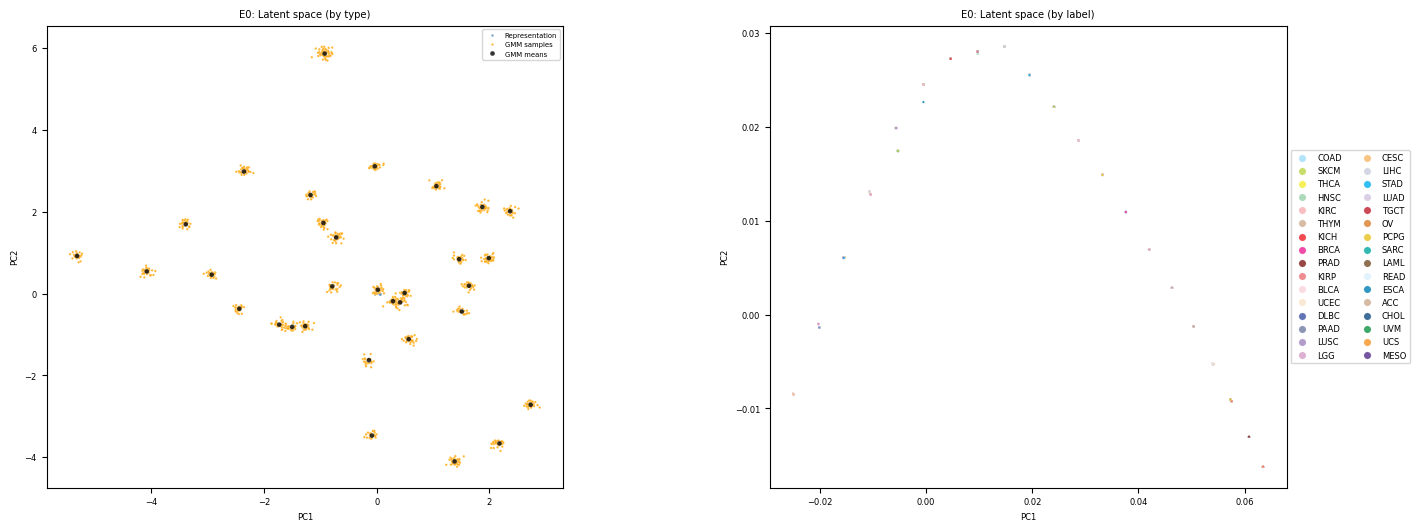

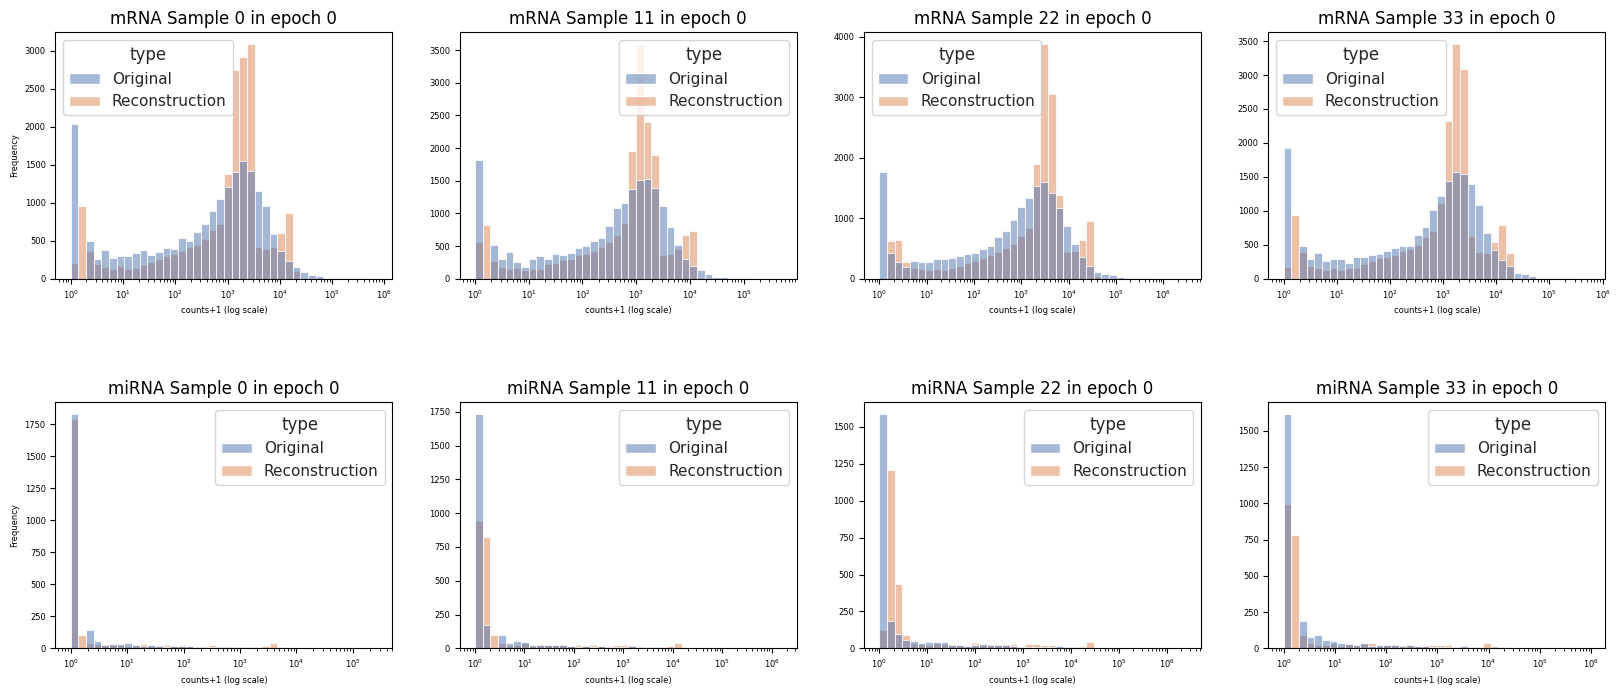

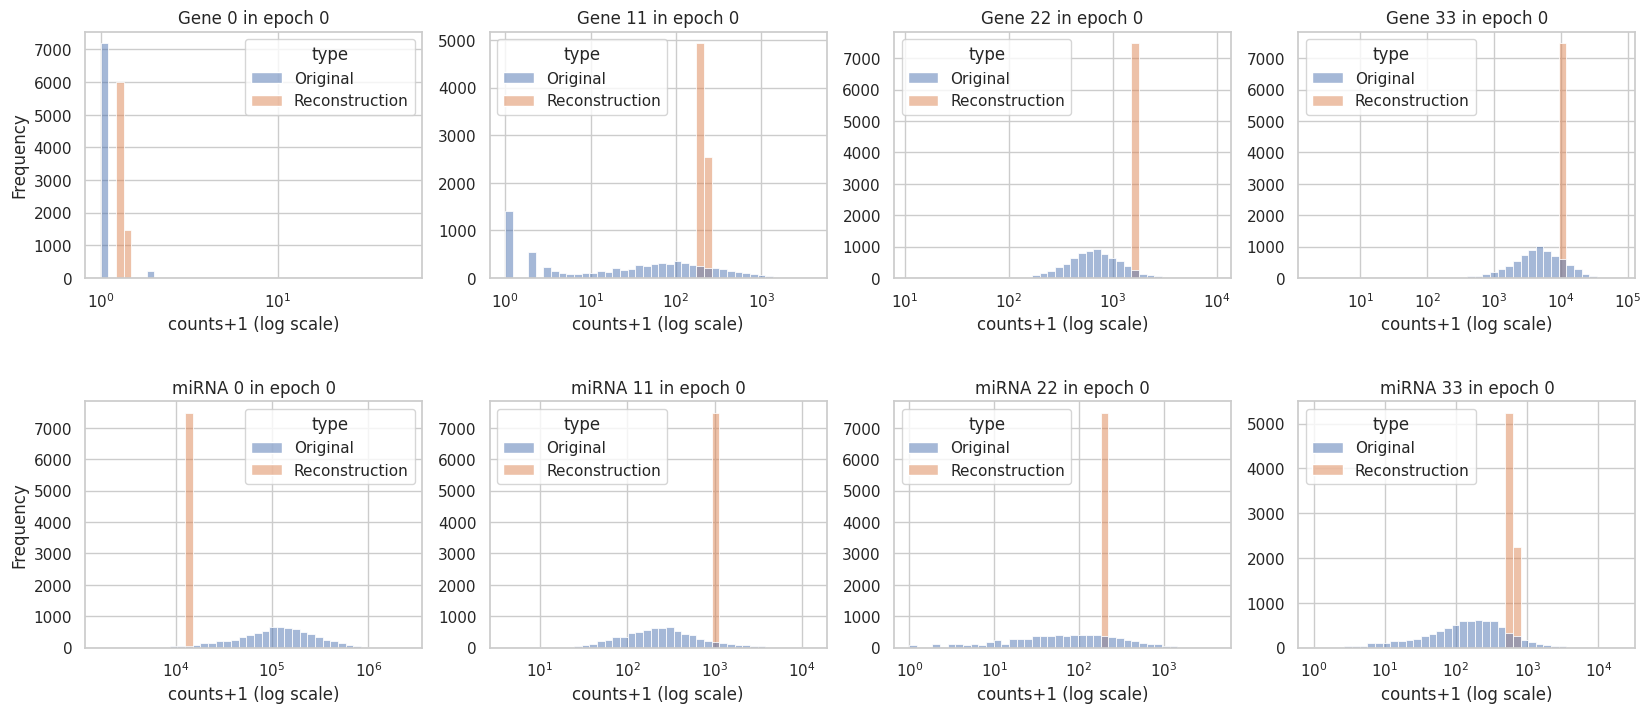

 13%|██████████████████████████████▌                                                                                                                                                                                                                 | 51/401 [07:06<48:32,  8.32s/it]

50 test_recon: 5.880935961529397 test_gmm: 2.8954868905176454 test_rmse: 0.23480194587397768 test_mse: 20.486706764082996 test_mae: 0.008967215906151528 test_r2: 0.0011226532237370412 test_corr: 0.002270637918903558


 25%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 101/401 [13:56<42:41,  8.54s/it]

100 test_recon: 5.69106626767014 test_gmm: 2.903560572188769 test_rmse: 0.2360681704176284 test_mse: 22.766997433244846 test_mae: 0.008284601474240153 test_r2: 0.0013697528973138013 test_corr: 0.0025165720256993653


 38%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 151/401 [20:43<32:26,  7.79s/it]

150 test_recon: 5.626196721296738 test_gmm: 2.902757126893348 test_rmse: 0.20060481465212782 test_mse: 12.681224358372209 test_mae: 0.007656808274749813 test_r2: 0.0015552475033962004 test_corr: 0.002688115049644532


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 200/401 [27:17<27:08,  8.10s/it]

200 test_recon: 5.601467908454491 test_gmm: 2.8978838833029164 test_rmse: 0.20456721647168458 test_mse: 14.22778488054341 test_mae: 0.007454956865995694 test_r2: 0.0016610348768192555 test_corr: 0.0027867386595745672


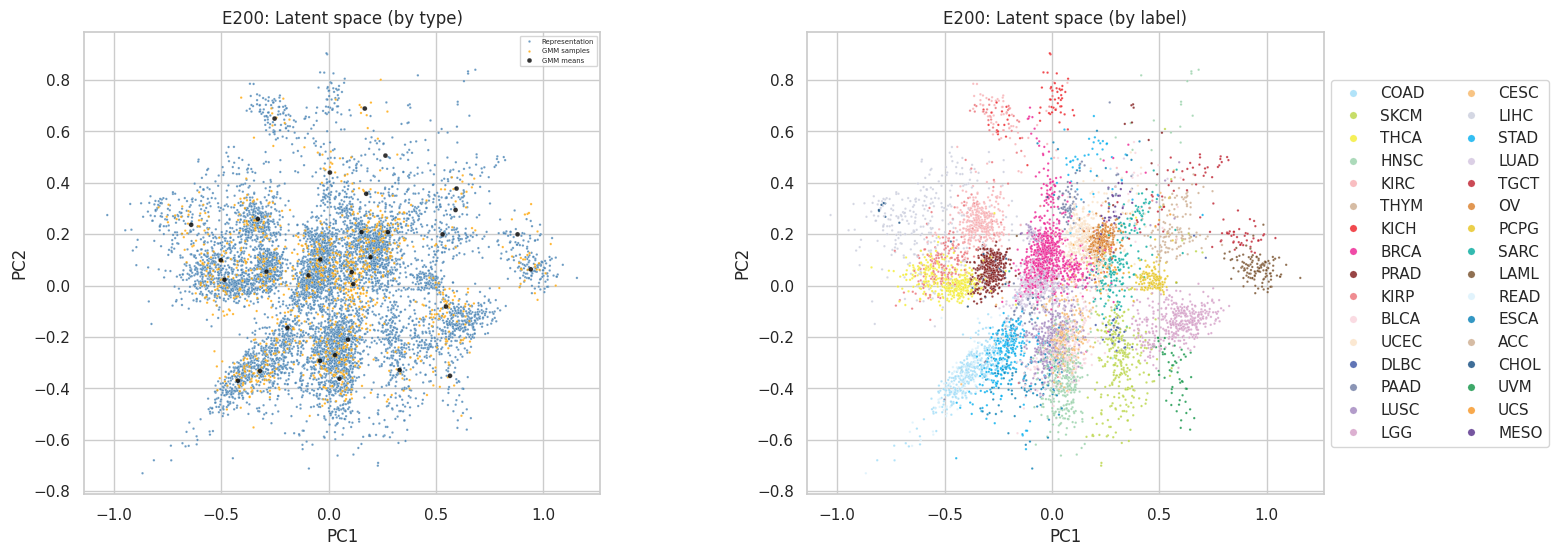

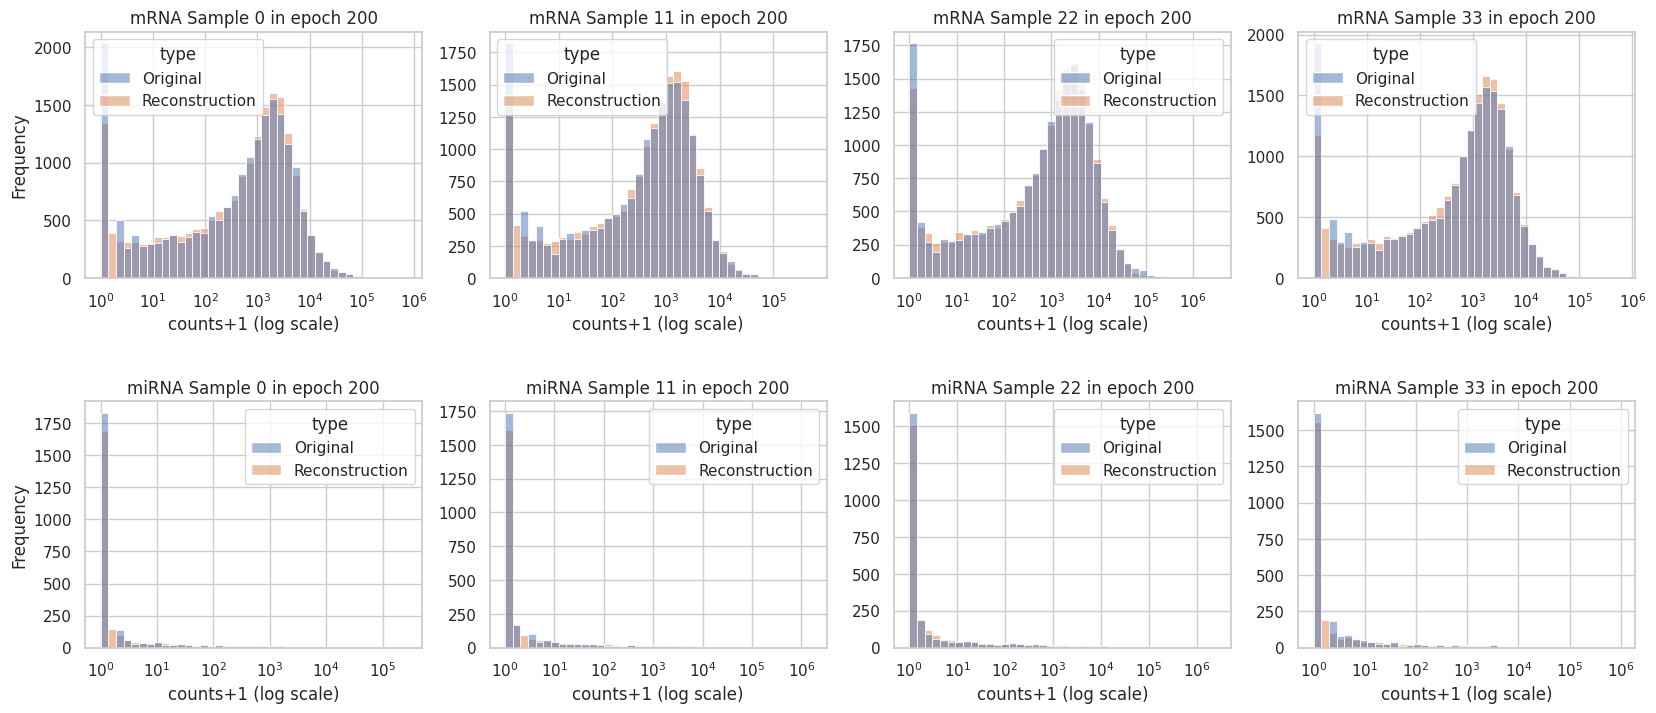

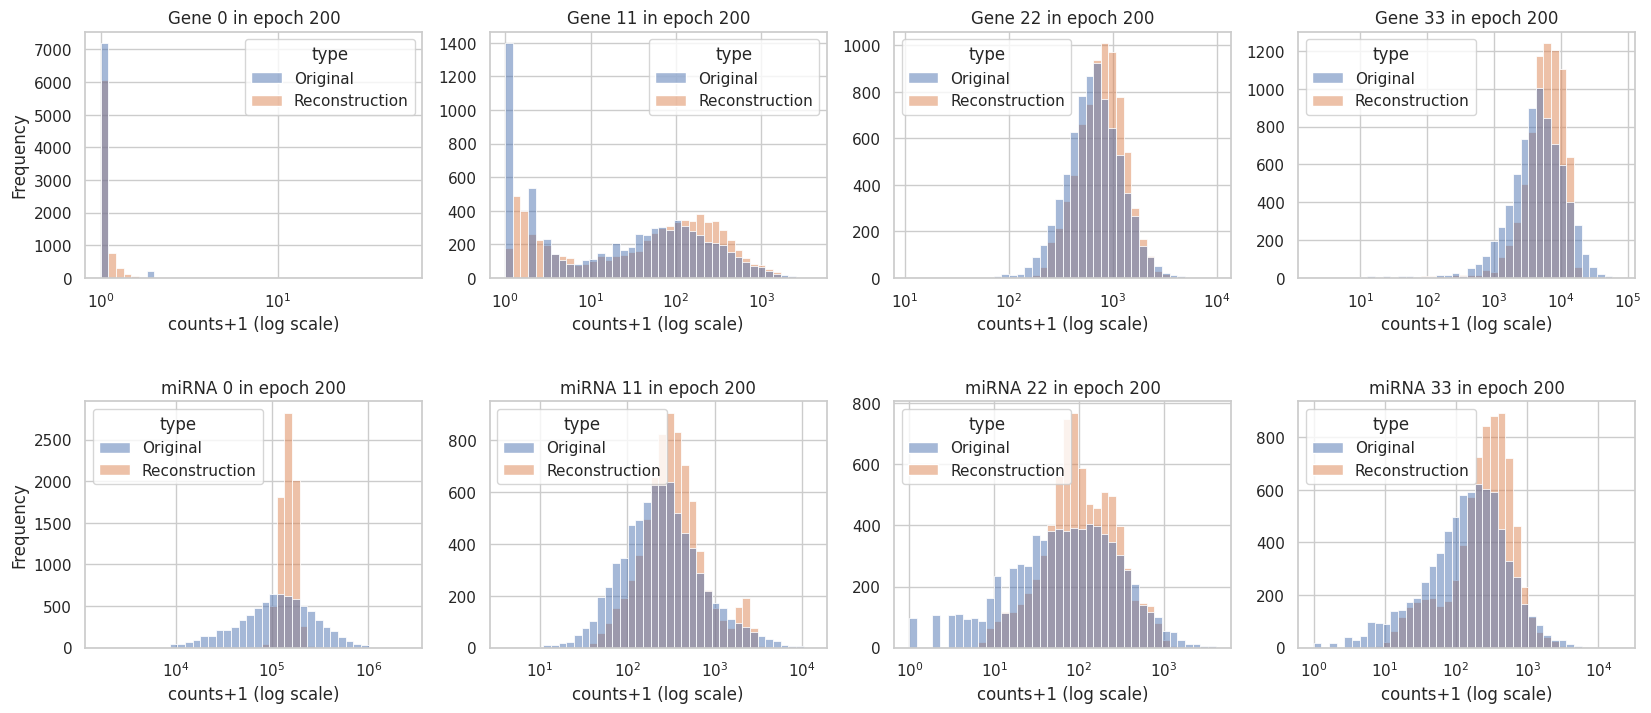

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 251/401 [34:15<20:26,  8.18s/it]

250 test_recon: 5.587529708567389 test_gmm: 2.896430789106418 test_rmse: 0.20109344615852884 test_mse: 13.855472257329403 test_mae: 0.007263340479429627 test_r2: 0.0017534623959152345 test_corr: 0.0028629728140941195


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 301/401 [40:51<12:50,  7.70s/it]

300 test_recon: 5.580313408284614 test_gmm: 2.8966304018972515 test_rmse: 0.2076351766211029 test_mse: 16.084726137045696 test_mae: 0.0071496932228083615 test_r2: 0.0018398580068651397 test_corr: 0.0029415986747908488


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 351/401 [47:45<06:38,  7.98s/it]

350 test_recon: 5.578259098879967 test_gmm: 2.897205802159783 test_rmse: 0.18228978592481263 test_mse: 10.206863203173798 test_mae: 0.006677850568986996 test_r2: 0.0019828179789512772 test_corr: 0.0030398049405185525


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 400/401 [54:28<00:07,  7.85s/it]

400 test_recon: 5.575749872867193 test_gmm: 2.897660725657304 test_rmse: 0.19679300283209225 test_mse: 14.069555107464573 test_mae: 0.006443504167303006 test_r2: 0.002033640376334634 test_corr: 0.0030900149476446263


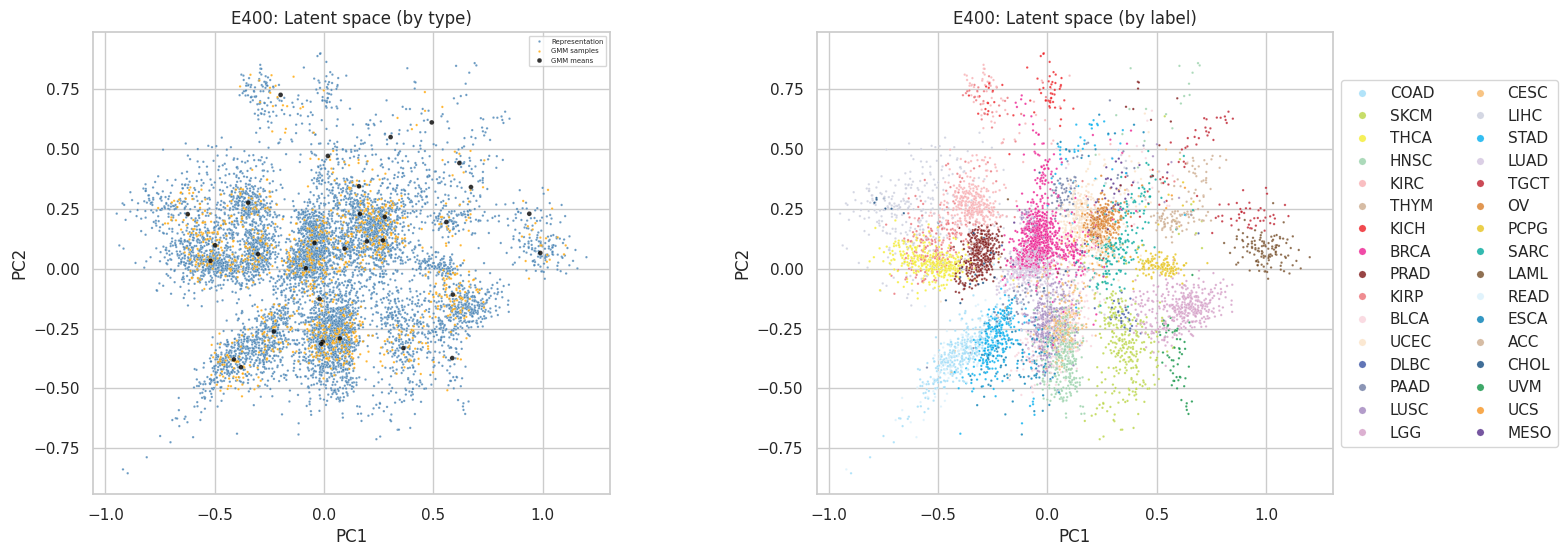

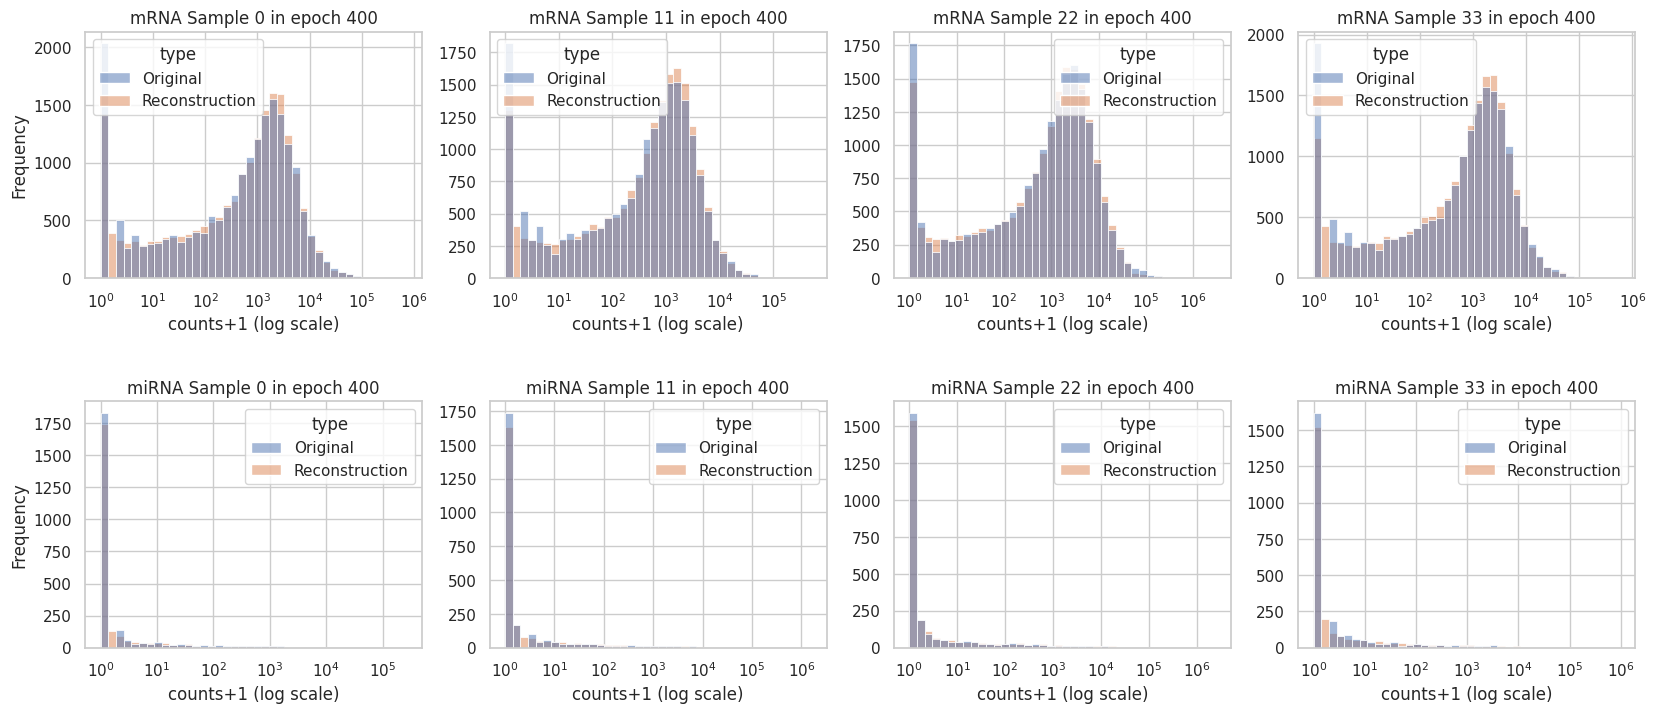

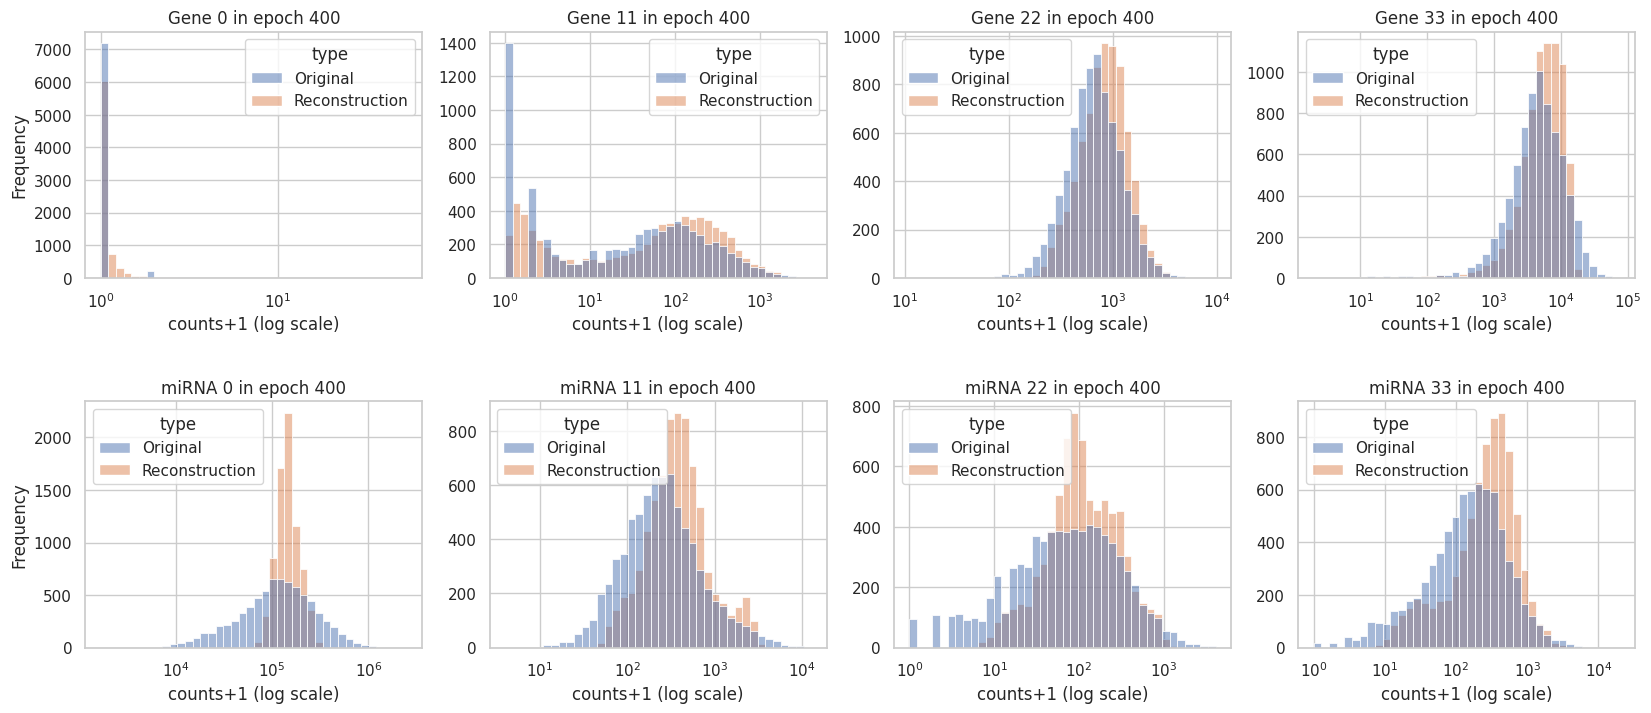

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [54:49<00:00,  8.20s/it]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test_corr,▁▂▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
test_gmm,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_mae,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁
test_mse,▆█▅▇▆▇▅▃▄▆▆▃▅▆▃▆▃▇▄▆▂▃▃▄▄▄▅▃▂▃▃▃▅▃▄▁▄▃▄▄
test_r2,▁▂▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇██████
test_recon,█▇▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_rmse,▇█▆▇▆▇▅▄▅▆▆▄▅▆▃▅▃▆▄▅▂▃▄▄▄▄▄▃▃▃▃▃▄▃▄▁▃▂▃▃
train_corr,▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train_gmm,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▇▆▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
train_mse,▆█▅▅▄▄▃▅▆▃▂▃▅▃▂█▂▂▅▄▂▂▂▃▂▂▃▂▃▃▃▁▃▂▂▃▁▁▁▂


In [15]:
learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01}
weight_decay=0.0001
betas=(0.5, 0.7)
nepochs = 801
pr = 50 # how often to print epoch
plot = 100 # how often to print plot
batch_size = 128
is_plot = True
n_splits=5

sample_mirna = ['MIMAT0000421', 'MIMAT0000422', 'MIMAT0000435', 'MIMAT0000728'] # miR-122-5p and miR-124-3p and others
sample_index = [tcga_mirna.columns.get_loc(a) for a in sample_mirna]
subset = sample_index[0]

loss_tab = train_midgd(
        dgd, train_loader, validation_loader, device, 
        learning_rates={'dec':0.002,'rep':0.01,'gmm':0.01},
        weight_decay=0.001,nepochs=n_epochs,pr=pr,plot=plot,reduction_type=reduction_type,
        wandb_log=True
    )

wandb.finish()

# Plotting Loss

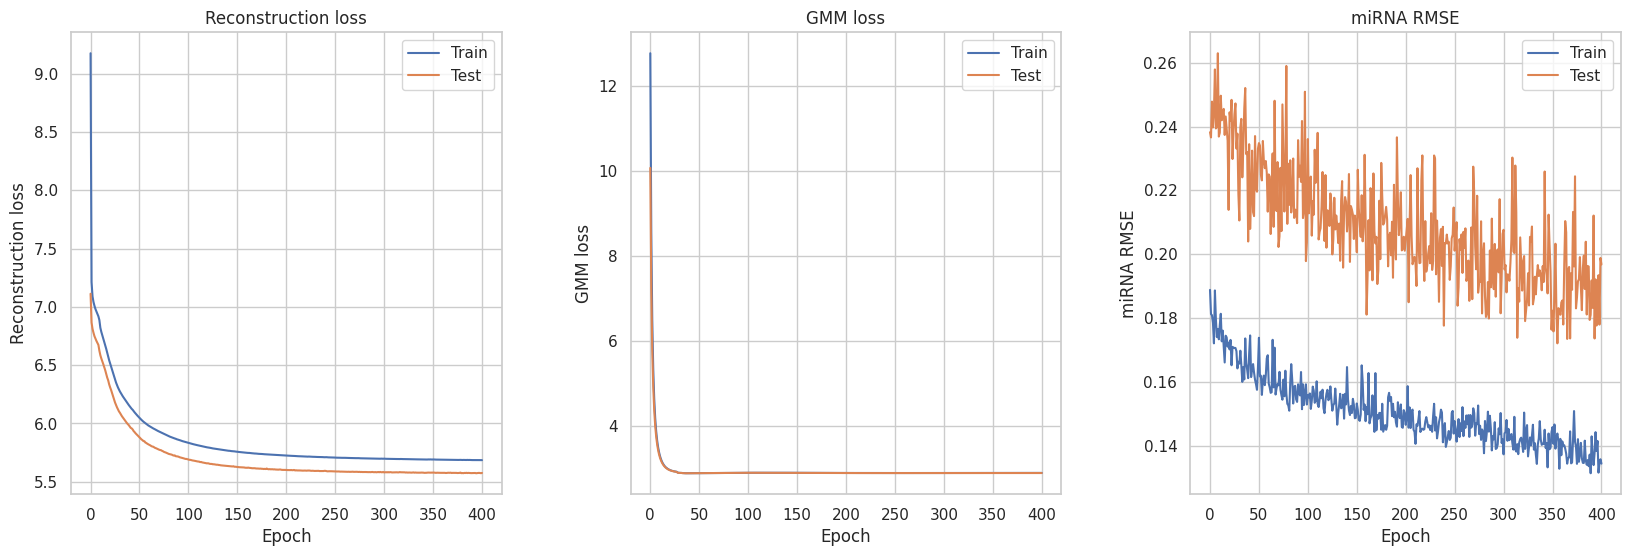

In [16]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon", data=loss_tab, label="Test")
plt.title("Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# Second subplot for GMM loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Third subplot for RMSE
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_rmse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_rmse", data=loss_tab, label="Test")
plt.title("miRNA RMSE")
plt.xlabel("Epoch")
plt.ylabel("miRNA RMSE")

# Display the plots
plt.show()

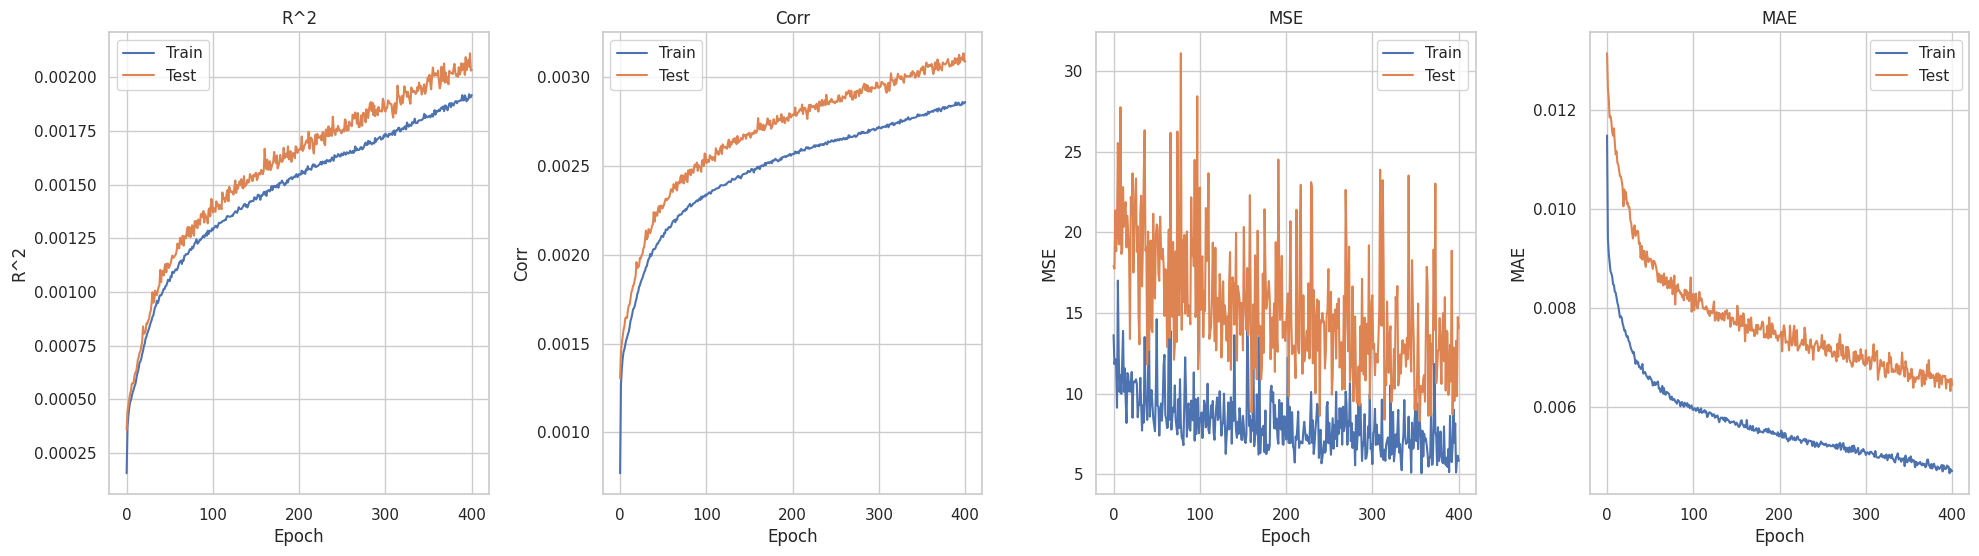

In [20]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for R-squared
plt.subplot(1, 4, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for Corr
plt.subplot(1, 4, 2)
sns.lineplot(x="epoch", y="train_corr", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_corr", data=loss_tab, label="Test")
plt.title("Corr")
plt.xlabel("Epoch")
plt.ylabel("Corr")

# Third subplot for MSE
plt.subplot(1, 4, 3)
sns.lineplot(x="epoch", y="train_mse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mse", data=loss_tab, label="Test")
plt.title("MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Fourth subplot for MAE
plt.subplot(1, 4, 4)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Display the plots
plt.show()

# Save Model

torch.save(dgd.state_dict(), "saved_model/05042024_leave_mirna.pth")